# Albumentations + Captum for Image Classification
---

This Homework explores the usage of `Albumentations` transformations for training Image Classification models. The data augmentation done by using this library will be compared to the performance of models trained without it. `Captum` is then used for running Model Interpretability algorithms on the model trained on the augmented data to gain more insights into how the classification is being done.


This process is done for two datasets -
1. Garbage Classification : [Kaggle Link](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification)
1. Cats vs. Dogs : [Link]("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip")

#### Install Albumentations and Captum

In [ ]:
# # Install stuff -- redirect input to /dev/null to avoid the cell output taking up too much space

# # Albumentations - For Image Transforms
# !pip install -U albumentations > /dev/null

# # Install specific versions of OpenCV for Colab -- there is currently a mismatch between opencv-python-headless and opencv-python versions
# # check versions to make sure all match
# # !pip list | grep opencv
# !pip uninstall -y opencv-python-headless==4.5.5.62
# !pip install opencv-python-headless==4.1.2.30 > /dev/null

# # Get Captum for insights
# !pip install captum > /dev/null

### Imports

In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from urllib.request import urlretrieve
from PIL import Image

# Import Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Import Captum Attributions
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## Dataset 1 - Garbage Classification

### Data and Transforms

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [3]:
dataset_directory = os.path.join("./datasets/")

This dataset needs to be downloaded from Kaggle, as without the API tokens we cannot download it using a CLI.

In [4]:
filepath = os.path.join(dataset_directory, "Garbage classification.zip")
extract_archive(filepath)

In [4]:
data_dir  = './datasets/Garbage classification/Garbage classification'

classes_alph = os.listdir(data_dir)
classes = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
print(classes)


['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']


In [5]:
class GarbageClassificationDataset(Dataset):
    """Dataset class for Garbage Collection Classification"""
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "glass":
            label = 0
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "paper":
            label = 1
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "cardboard":
            label = 2
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "plastic":
            label = 3
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "metal":
            label = 4
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "trash":
            label = 5
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [6]:
root_directory = os.path.join(dataset_directory, "Garbage classification/Garbage classification")

glass_directory = os.path.join(root_directory, "glass")
paper_directory = os.path.join(root_directory, "paper")
cardboard_directory = os.path.join(root_directory, "cardboard")
plastic_directory = os.path.join(root_directory, "plastic")
metal_directory = os.path.join(root_directory, "metal")
trash_directory = os.path.join(root_directory, "trash")

glass_images_filepaths = sorted([os.path.join(glass_directory, f) for f in os.listdir(glass_directory)])
paper_images_filepaths = sorted([os.path.join(paper_directory, f) for f in os.listdir(paper_directory)])
cardboard_images_filepaths = sorted([os.path.join(cardboard_directory, f) for f in os.listdir(cardboard_directory)])
plastic_images_filepaths = sorted([os.path.join(plastic_directory, f) for f in os.listdir(plastic_directory)])
metal_images_filepaths = sorted([os.path.join(metal_directory, f) for f in os.listdir(metal_directory)])
trash_images_filepaths = sorted([os.path.join(trash_directory, f) for f in os.listdir(trash_directory)])

images_filepaths = [*glass_images_filepaths, *paper_images_filepaths, *cardboard_images_filepaths, *plastic_images_filepaths,
                    *metal_images_filepaths, *trash_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [7]:
print(len(correct_images_filepaths))

2527


In [8]:
# Split into train, val and test sets
random.seed(42)     # reproducibility
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:1700]
val_images_filepaths = correct_images_filepaths[1700:-500]
test_images_filepaths = correct_images_filepaths[-500:]
print('Train Images:', len(train_images_filepaths), '\nVal Images:', len(val_images_filepaths), '\nTest Images:', len(test_images_filepaths))

Train Images: 1700 
Val Images: 327 
Test Images: 500


In [9]:
# Standard Transformation is just resizing
standard_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ]
)

# Add Albumentations transformations for augmenting training data
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ]
)

# Create two datasets for comparing -- with and without Augmentation
train_dataset = GarbageClassificationDataset(images_filepaths=train_images_filepaths, transform=train_transform)
train_dataset_no_aug = GarbageClassificationDataset(images_filepaths=train_images_filepaths, transform=standard_transform)

In [10]:
# Validation Set transformation -- just Normalize and Resize
val_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ]
)

# Create two datasets, just as for training data
val_dataset = GarbageClassificationDataset(images_filepaths=val_images_filepaths, transform=val_transform)
val_dataset_no_aug = GarbageClassificationDataset(images_filepaths=val_images_filepaths, transform=standard_transform)

In [11]:
# Test Set transformation -- same as for validation set
test_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ]
)

test_dataset = GarbageClassificationDataset(images_filepaths=test_images_filepaths, transform=val_transform)
test_dataset_no_aug = GarbageClassificationDataset(images_filepaths=test_images_filepaths, transform=standard_transform)

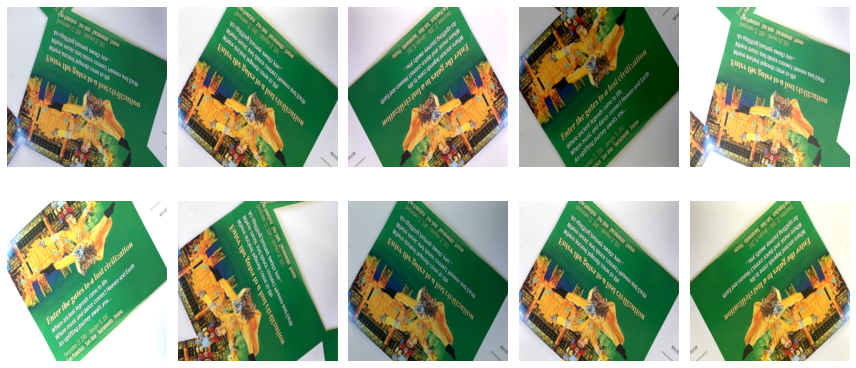

In [12]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    """Visualize the possible augmentations for an image"""
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


random.seed(42)
visualize_augmentations(train_dataset)

### Model Definitions

We use a pre-trained ResNet-50 Model for this task and replace the final layer to output the 6 classes in our dataset.

In [13]:
def accuracy(outputs, labels):
    """Retrieve Accuracy"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    """Base Class for Image Classification"""

    def training_step(self, batch):
        """Forward Propagation during training phase"""
        images, labels = batch
        out = self(images.float())
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        """Forward Propagation during validation"""
        images, labels = batch 
        out = self(images.float())
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        """Calculate metrics at the end of validation epoch"""
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        """Print metrics at the end of training + validation epoch"""
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

class ResNet(ImageClassificationBase):
    """Pre-trained ResNet50 model with modified final layer"""
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet50(pretrained=True)
        
        # Replace the final layer according to the number of classes in our dataset
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(classes))
    
    def forward(self, x):
        x = self.network(x)
        return torch.sigmoid(x)

In [14]:
def get_default_device():
    """Find and get default device"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move data tensors to given device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Generator for DataLoader to move data to device for each yield"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluation function for validation/test set data"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Fit function for training and validation"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    """Show Image and Label in a Grid"""
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

def show_images(test_loader, model, start=0, end=20):
    """Create a Grid showing an Image and its predicted label"""
    model = model.eval()
    predicted_labels = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device, non_blocking=True).float()
            output = model(images)
            _, pred_label_idx = torch.max(output, dim=1)
            predicted_labels += [classes[pdx] for pdx in pred_label_idx]

    display_image_grid(test_images_filepaths[start:end], predicted_labels[start:end])

### Model without Augmentation

In [17]:
# Set parameters for DataLoaders
params = {
    "batch_size": 32,
    "num_workers": 4,
}

In [18]:
# Create Train and Validation DataLoaders for data created without augmentation
train_loader_no_aug = DataLoader(
    train_dataset_no_aug, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader_no_aug = DataLoader(
    val_dataset_no_aug, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_loader_no_aug = DataLoader(
    test_dataset_no_aug, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [19]:
train_dl_no_aug = DeviceDataLoader(train_loader_no_aug, device)
val_dl_no_aug = DeviceDataLoader(val_loader_no_aug, device)
test_dl_no_aug = DeviceDataLoader(test_loader_no_aug, device)

In [20]:
model_no_aug = to_device(ResNet(), device)

In [21]:
# Before training
results_no_aug = evaluate(model_no_aug, val_dl_no_aug)
print('Validation Loss:', results_no_aug['val_loss'], ', Validation Accuracy:', results_no_aug['val_acc'])

Validation Loss: 1.9453864097595215 , Validation Accuracy: 0.14772726595401764


In [22]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model_no_aug, train_dl_no_aug, val_dl_no_aug, opt_func)

Epoch 1: train_loss: 1.4607, val_loss: 1.2342, val_acc: 0.8450
Epoch 2: train_loss: 1.1800, val_loss: 1.1419, val_acc: 0.9318
Epoch 3: train_loss: 1.0990, val_loss: 1.1018, val_acc: 0.9688
Epoch 4: train_loss: 1.0816, val_loss: 1.1035, val_acc: 0.9517
Epoch 5: train_loss: 1.0756, val_loss: 1.1055, val_acc: 0.9489
Epoch 6: train_loss: 1.0727, val_loss: 1.0923, val_acc: 0.9631
Epoch 7: train_loss: 1.0657, val_loss: 1.0858, val_acc: 0.9716
Epoch 8: train_loss: 1.0543, val_loss: 1.0772, val_acc: 0.9744


In [23]:
# Validation Results after Training
val_results_no_aug = evaluate(model_no_aug, val_dl_no_aug)
print('Validation Loss:', val_results_no_aug['val_loss'], ', Validation Accuracy:', val_results_no_aug['val_acc'])

Validation Loss: 1.0771535634994507 , Validation Accuracy: 0.9744318127632141


In [24]:
# Results on Test Set after training
test_results_no_aug = evaluate(model_no_aug, test_dl_no_aug)
print('Test Loss:', test_results_no_aug['val_loss'], ', Test Accuracy:', test_results_no_aug['val_acc'])

Test Loss: 1.1173954010009766 , Test Accuracy: 0.934374988079071


In [25]:
# Clear GPU memory
del train_dl_no_aug, val_dl_no_aug, test_dl_no_aug, model_no_aug
torch.cuda.empty_cache()

### Model with Augmentation

In [26]:
# Create Train and Validation DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [27]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [28]:
model_aug = to_device(ResNet(), device)

In [29]:
# Validation check before Training
val_results = evaluate(model_aug, val_dl)
print('Validation Loss:', val_results['val_loss'], ', Validation Accuracy:', val_results['val_acc'])

Validation Loss: 1.7884061336517334 , Validation Accuracy: 0.1505681872367859


In [30]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model_aug, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4859, val_loss: 1.2479, val_acc: 0.8535
Epoch 2: train_loss: 1.2204, val_loss: 1.1464, val_acc: 0.9217
Epoch 3: train_loss: 1.1484, val_loss: 1.1306, val_acc: 0.9075
Epoch 4: train_loss: 1.1263, val_loss: 1.1030, val_acc: 0.9489
Epoch 5: train_loss: 1.1192, val_loss: 1.0888, val_acc: 0.9602
Epoch 6: train_loss: 1.1074, val_loss: 1.0899, val_acc: 0.9631
Epoch 7: train_loss: 1.0956, val_loss: 1.0721, val_acc: 0.9830
Epoch 8: train_loss: 1.0897, val_loss: 1.0832, val_acc: 0.9688


In [31]:
# Validation check after training
val_results = evaluate(model_aug, val_dl)
print('Validation Loss:', val_results['val_loss'], ', Validation Accuracy:', val_results['val_acc'])

Validation Loss: 1.0832226276397705 , Validation Accuracy: 0.96875


In [37]:
# Results on Test set
test_results = evaluate(model_aug, test_dl)
print('Test Loss:', test_results['val_loss'], ', Test Accuracy:', test_results['val_acc'])

Test Loss: 1.111262321472168 , Test Accuracy: 0.934374988079071


We observe that the Test Losses for both models are quite similar.

In [34]:
# Save/Load model if needed
# torch.save(model, './aug_model.pth')
# model = torch.load('./aug_model.pth')

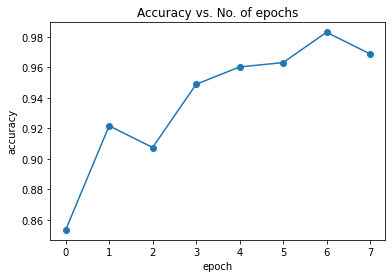

In [33]:
def plot_accuracies(history):
    """Plot Validation Accuracies"""
    accuracies = [h['val_acc'] for h in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

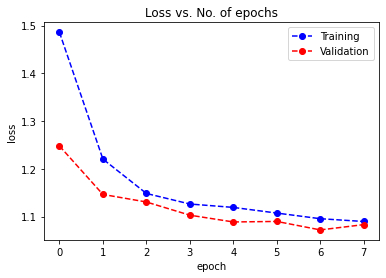

In [34]:
def plot_losses(history):
    """Plot Training vs. Validation Loss"""
    train_losses = [h.get('train_loss') for h in history]
    val_losses = [h['val_loss'] for h in history]
    plt.plot(train_losses, '--bo')
    plt.plot(val_losses, '--ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

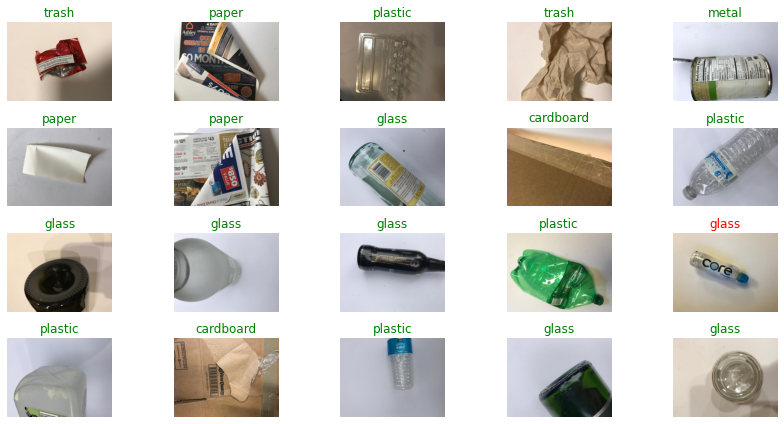

In [35]:
show_images(test_dl, model_aug, 270, 290)

In [36]:
del train_dl, val_dl
torch.cuda.empty_cache()

### Captum Analysis

We take up two different ways to visualize Attributions on external images to help identify what regions of the image help in classifying the model as such.

These methods are taken directly from the tutorial at Captum : Link to [Captum.ai tutorial](https://captum.ai/tutorials/Resnet_TorchVision_Interpret)


#### Gradient-based Attribution
1. **Integrated Gradients**: As mentioned in the tutorial, __Integrated Gradients__ computes the integral of the gradients of the output of the model for the predicted class pred_label_idx with respect to the input image pixels along the path from the black image to our input image. The first output for every image shows the attributions from this method.
1. **Noise Tunnels**: Noise Tunnels smoothen the attributions over multiple samples by adding Gaussian Noise `nt_samples` number of times (10 in our case). This is shown in the second output for every image.
1. **GradientShap**: GradientShap approximates SHAP values by computing the expectations of gradients by randomly sampling from the distribution of baselines/references. It adds white noise to each input sample `n_samples` times, selects a random baseline from baselines’ distribution and a random point along the path between the baseline and the input, and computes the gradient of outputs with respect to those selected random points. The final SHAP values represent the expected values of `gradients * (inputs - baselines)`. This is the third output for every image.


#### Occlusion-based Attribution
Occlusion-based Attribution blocks (occludes) certain parts of the image and sees how that affects the classifier's decision. This can show us the areas that a classifier considers important for that particular classification. The occlusion is done by running a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via strides). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

In [38]:
def integrated_gradients_wrapper(model, input_img, original_img, predicted_label_index, n_steps=200):
    predicted_label_index.squeeze_()
    int_grads = IntegratedGradients(model)
    attributions_ig = int_grads.attribute(input_img, target=predicted_label_index, n_steps=n_steps, internal_batch_size=1)

    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                np.transpose(original_img, (0, 1, 2)),
                                method='heat_map',
                                cmap=default_cmap,
                                show_colorbar=True,
                                sign='positive',
                                outlier_perc=1)
    
    del attributions_ig
    torch.cuda.empty_cache()
    
    return int_grads

def noise_tunnel_wrapper(integrated_gradients, input_img, original_img, predicted_label_index):
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label_index, nt_samples_batch_size=1)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        original_img,
                                        ["original_image", "heat_map"],
                                        ["all", "positive"],
                                        cmap=default_cmap,
                                        show_colorbar=True)
    
    del attributions_ig_nt
    torch.cuda.empty_cache()


def gradient_shap_wrapper(model, input_img, original_img, predicted_label_index):
    torch.manual_seed(0)
    np.random.seed(0)

    gradient_shap = GradientShap(model)

    # Defining baseline distribution of images
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])

    attributions_gs = gradient_shap.attribute(input_img,
                                            n_samples=50,
                                            stdevs=0.0001,
                                            baselines=rand_img_dist,
                                            target=predicted_label_index)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        original_img,
                                        ["original_image", "heat_map"],
                                        ["all", "absolute_value"],
                                        cmap=default_cmap,
                                        show_colorbar=True)
    
    del attributions_gs
    torch.cuda.empty_cache()


def occlusion_wrapper(model, input_img, original_img, predicted_label_idx):
    occlusion = Occlusion(model)

    attributions_occ = occlusion.attribute(input_img,
                                        strides = (3, 8, 8),
                                        target=predicted_label_idx,
                                        sliding_window_shapes=(3,15, 15),
                                        baselines=0)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      original_img,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
    
    del attributions_occ
    torch.cuda.empty_cache()

In [39]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

def test_garbage_classification(model, test_img_path):
    """Evaluating function for Garbage Classification Model"""
    model = model.eval()
    test_img = np.array(Image.open(test_img_path))

    img_transformed = test_transform(image=test_img)['image']
    inp = img_transformed.unsqueeze(0).to(device)

    output = model(inp)
    prediction_score, preds = torch.max(output, dim=1)
    predicted_label = classes[preds]
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    return inp, test_img, preds

In [40]:
def run_captum_functions(model, inp, img_transformed, pred_label_idx):
    """Helper util for running Captum Functions"""
    int_grads = integrated_gradients_wrapper(model, inp, img_transformed, pred_label_idx)
    noise_tunnel_wrapper(int_grads, inp, img_transformed, pred_label_idx)
    gradient_shap_wrapper(model, inp, img_transformed, pred_label_idx)
    occlusion_wrapper(model, inp, img_transformed, pred_label_idx)

def run_test_captum(model, test_images_filepaths, run_func):
    """Helper util for running Captum Functions over multiple files"""
    for test_image_path in test_images_filepaths:
        inp, img_transformed, predicted_idx = run_func(model, test_image_path)
        run_captum_functions(model, inp, img_transformed, predicted_idx)

Predicted: cardboard ( 0.9983692765235901 )


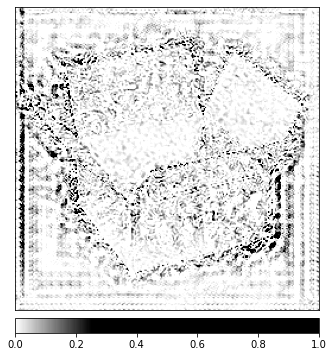

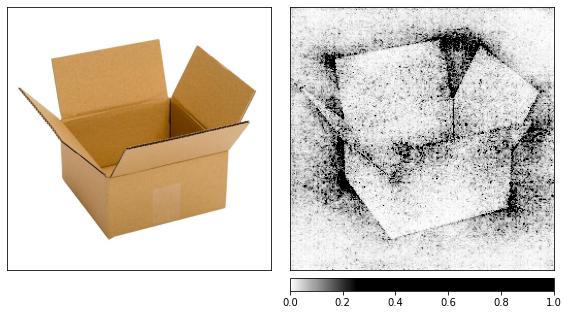

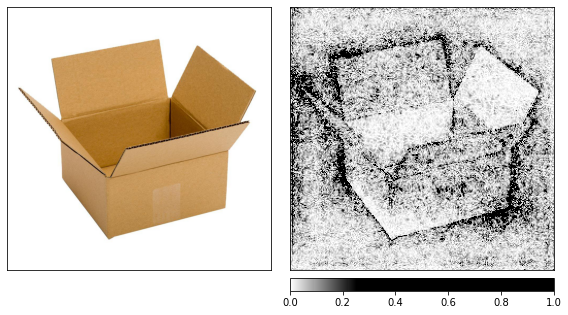

In [41]:
run_test_captum(model_aug, ['./test_images/gc/cardboard.jpg'], test_garbage_classification)

As can be seen above images, the edges of a cardboard box are crucial for its classification.

Predicted: glass ( 0.41600552201271057 )


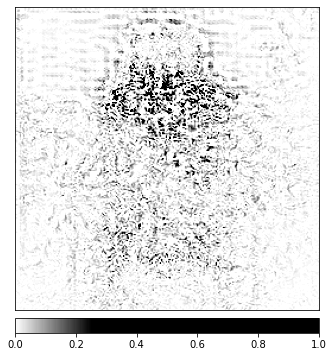

/home/horizon/anaconda3/envs/torch110/lib/python3.8/site-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


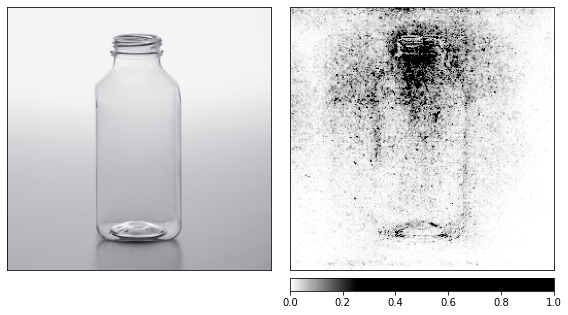

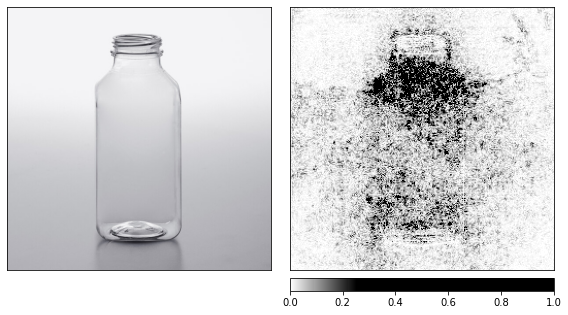

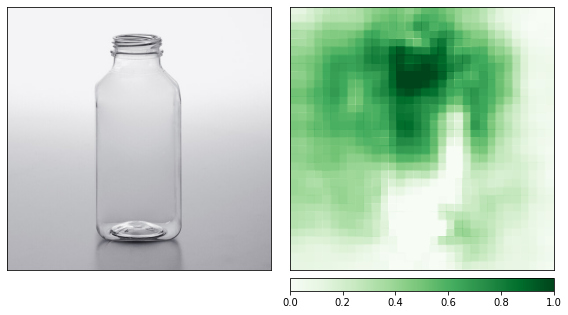

In [42]:
run_test_captum(model_aug, ['./test_images/gc/glass.jpg'], test_garbage_classification)

A glass bottle's mouth region as well as the top parts of the bottle contribute to its classification.

Predicted: metal ( 0.9943816065788269 )


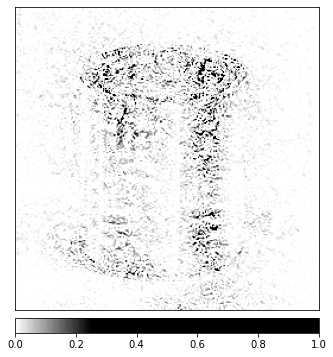

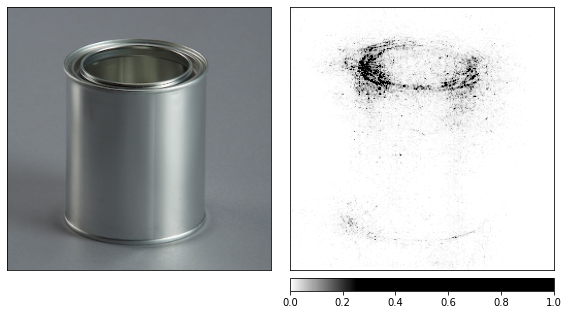

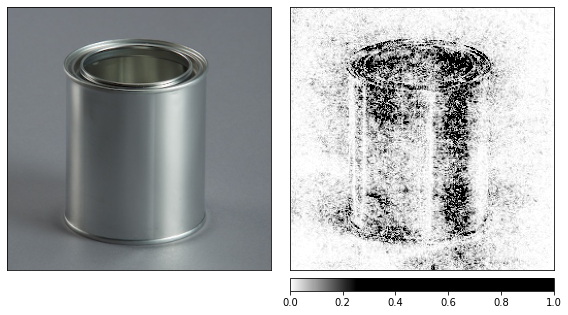

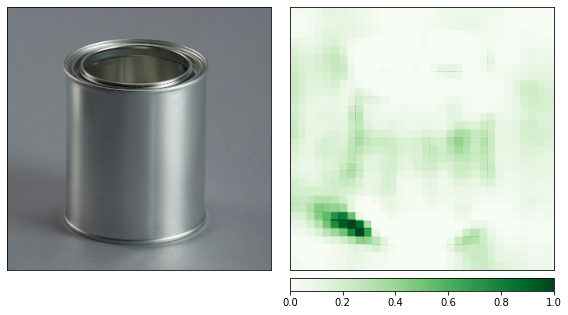

In [43]:
run_test_captum(model_aug, ['./test_images/gc/metal.jpg'], test_garbage_classification)

A metal object's round base and rounded corners and edges are deemed important as per the above images.

Predicted: paper ( 0.9367392659187317 )


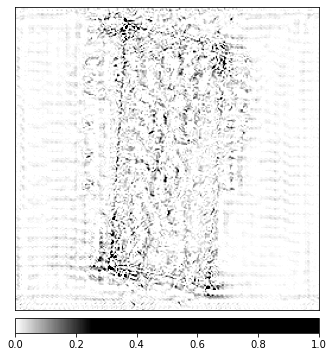

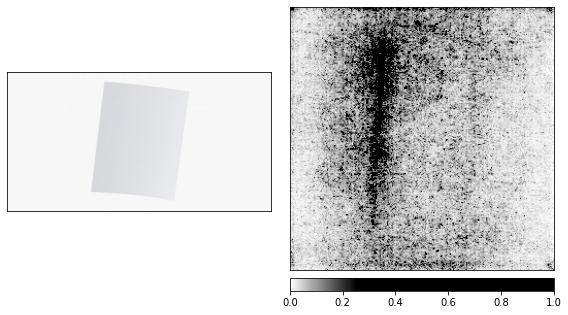

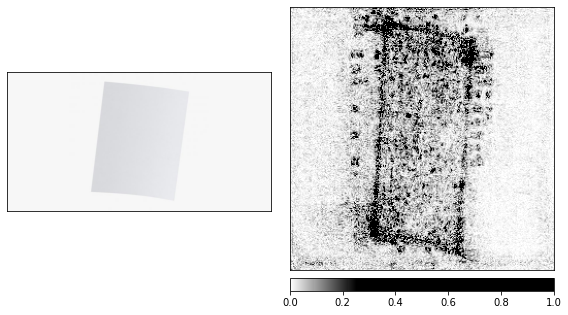

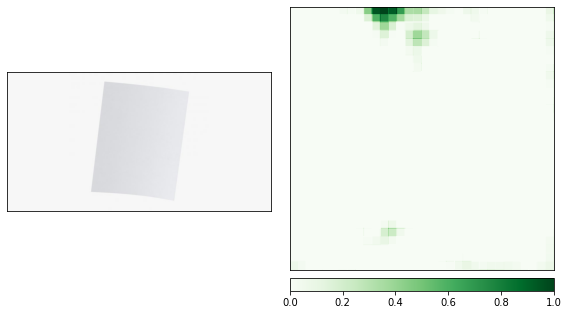

In [44]:
run_test_captum(model_aug, ['./test_images/gc/paper.jpg'], test_garbage_classification)

The edges of a paper are important for its classification. Interestingly, in the above example, occlusion-based attribution shows that the edges on the left are contributing more to the classification than the edges on the right.

Predicted: trash ( 0.7677358388900757 )


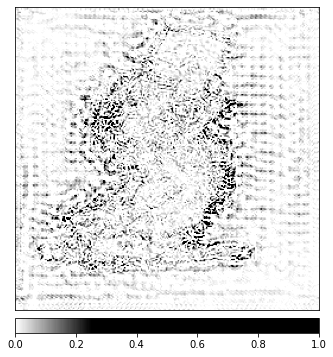

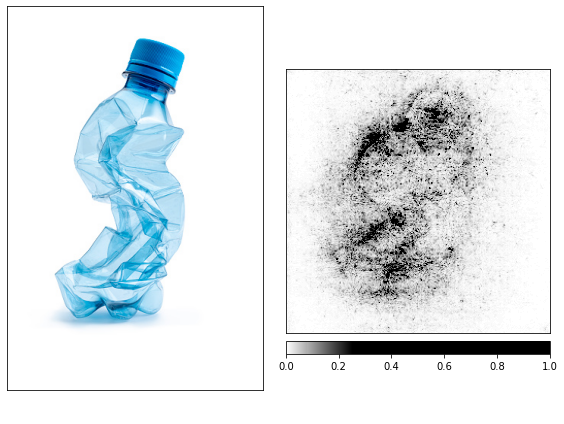

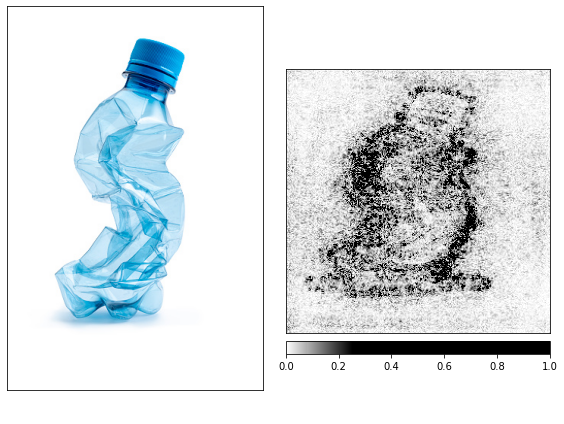

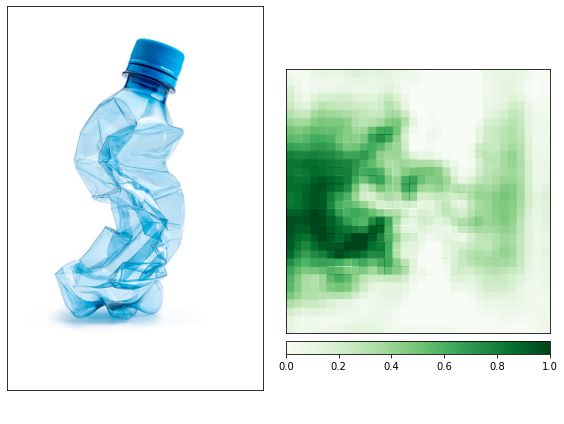

In [45]:
run_test_captum(model_aug, ['./test_images/gc/plastic.jpg'], test_garbage_classification)

The example plastic bottle is crushed in this scenario, and all the curves along its main body seem to be contributing to its classification as such.

Predicted: cardboard ( 0.756528377532959 )


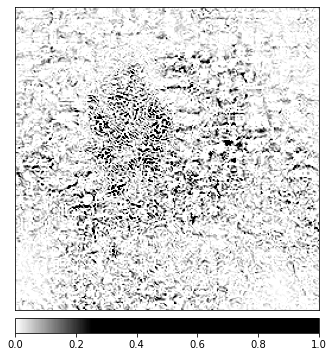

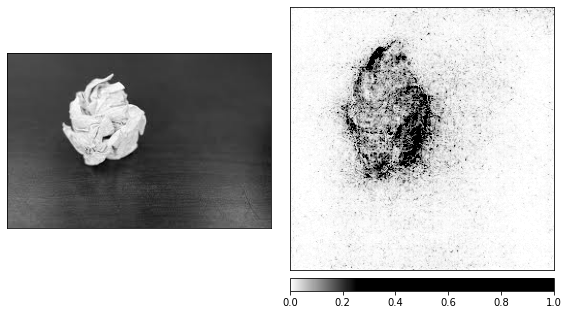

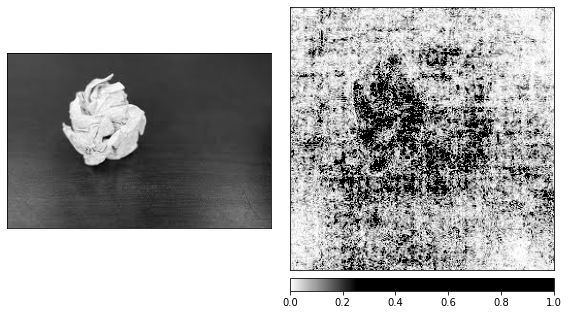

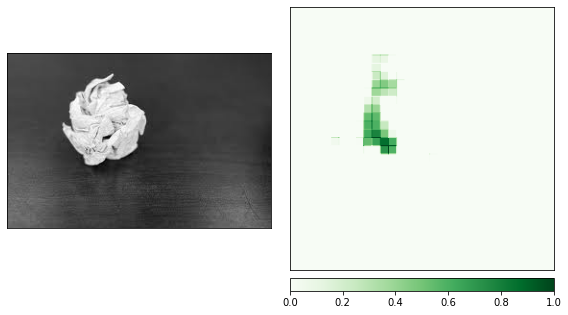

In [46]:
run_test_captum(model_aug, ['./test_images/gc/trash.jpg'], test_garbage_classification)

The Trash class seems to be dependent on arbitrary-shaped curves in the gradient and occlusion-based attributions.

In [ ]:
# # Run for all files in test_images/gc folder
# external_test_images = []
# external_test_images += [os.path.join('./test_images/gc/', im) for im in os.listdir('./test_images/gc/')]
# run_test_captum(model_aug, external_test_images, test_garbage_classification)

In [47]:
del model_aug
torch.cuda.empty_cache()

# Dataset 2 - Cats vs Dogs

### Data and Transforms

In [48]:
# Set dataset directory to local runtime's storage
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dataset_directory = os.path.join("./datasets/")

In [49]:
# Load the Cats vs. Dogs dataset
filepath = os.path.join(dataset_directory, "kagglecatsanddogs_3367a.zip")
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)

# Extract
extract_archive(filepath)

Filepath already exists. Skipping download.


In [50]:
# Fix broken files, load only those files that OpenCV can open
root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


In [51]:
# Split into train, val and test sets
random.seed(42)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:18000]
val_images_filepaths = correct_images_filepaths[18000:-2000]
test_images_filepaths = correct_images_filepaths[-2000:]
print('Train Images:', len(train_images_filepaths), '\nVal Images:', len(val_images_filepaths), '\nTest Images:', len(test_images_filepaths))

Train Images: 18000 
Val Images: 4946 
Test Images: 2000


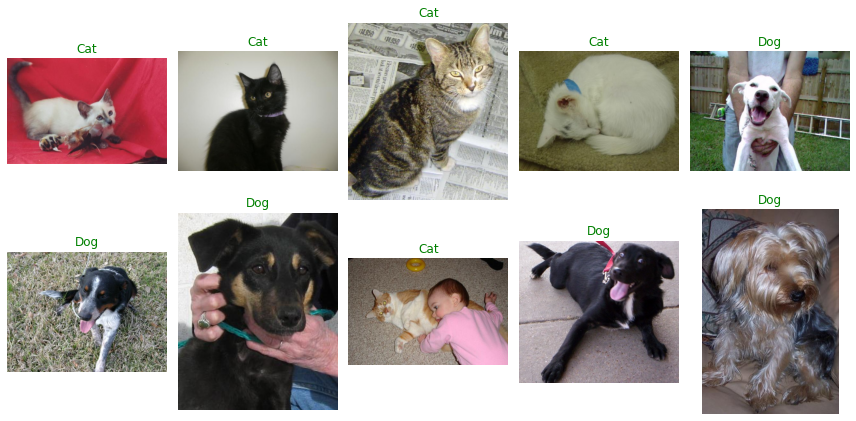

In [52]:
display_image_grid(test_images_filepaths[:10])

In [53]:
class CatsVsDogsDataset(Dataset):
    """Dataset class for Cats vs. Dogs Classification"""
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = torch.Tensor([1.0, 0.0])
        else:
            label = torch.Tensor([0.0, 1.0])
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [54]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

transform_no_aug = A.Compose(
    [
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)
train_dataset_untransformed = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=transform_no_aug)

In [55]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)
val_dataset_untransformed = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=transform_no_aug)

In [56]:
test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_dataset_untransformed = CatsVsDogsDataset(images_filepaths=test_images_filepaths, transform=transform_no_aug)

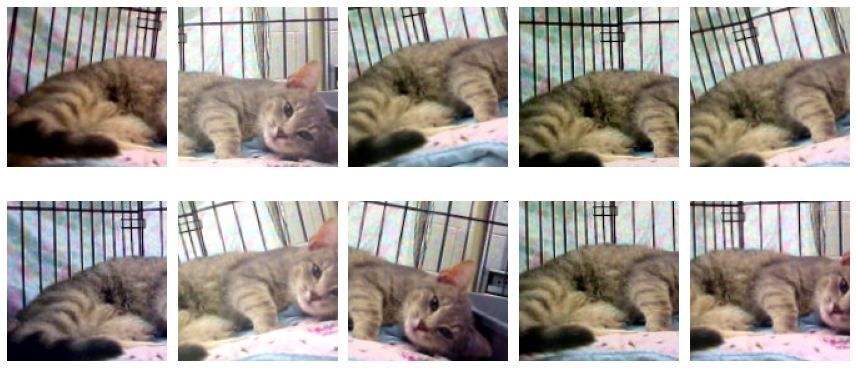

In [57]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


random.seed(42)
visualize_augmentations(train_dataset)

### Model Definitions

In [58]:
def calculate_accuracy(output, target):
    """Util to calculate accuracy"""
    F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    _, target = torch.topk(target, 1)
    return torch.true_divide((target == pred_label_idx).sum(dim=0), output.size(0)).item()

In [59]:
class MetricMonitor:
    """Helper util for metric monitoring"""
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

We use a ResNet-18 Model for this task that is not pre-trained. We train it from scratch with the parameters given below.

In [60]:
params = {
    "model": "resnet18",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 10,
}

In [61]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True).float()
        target = target.to(params["device"], non_blocking=True).float().view(-1, 2)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True).float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 2)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

def test(test_loader, model, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True).float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 2)
            output = model(images)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Testing. {metric_monitor}".format(metric_monitor=metric_monitor)
            )

def show_images(test_loader, model, start=0, end=10):
    model = model.eval()
    predicted_labels = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(params["device"], non_blocking=True).float()
            output = model(images)
            output = F.softmax(output, dim=1)
            _, pred_label_idx = torch.topk(output, 1)
            predicted_labels += ['Cat' if pdx == 0.0 else 'Dog' for pdx in pred_label_idx]

    display_image_grid(test_images_filepaths[start:end], predicted_labels)

### Model without Augmentation

In [62]:
# No Augmentation
train_dl_no_aug = DataLoader(
    train_dataset_untransformed, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_dl_no_aug = DataLoader(
    val_dataset_untransformed, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_dl_no_aug = DataLoader(
    test_dataset_untransformed, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [63]:
model_no_aug = getattr(models, params["model"])(pretrained=False, num_classes=2,)
model_no_aug = model_no_aug.to(params["device"])
criterion_no_aug = nn.BCEWithLogitsLoss().to(params["device"])
optimizer_no_aug = torch.optim.Adam(model_no_aug.parameters(), lr=params["lr"])

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_dl_no_aug, model_no_aug, criterion_no_aug, optimizer_no_aug, epoch, params)
    validate(val_dl_no_aug, model_no_aug, criterion_no_aug, epoch, params)

### Model with Augmentation

In [65]:
train_dl = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_dl = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_dl = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [66]:
model_aug = getattr(models, params["model"])(pretrained=False, num_classes=2,)
model_aug = model_aug.to(params["device"])
criterion_aug = nn.BCEWithLogitsLoss().to(params["device"])
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=params["lr"])

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_dl, model_aug, criterion_aug, optimizer_aug, epoch, params)
    validate(val_dl, model_aug, criterion_aug, epoch, params)

In [70]:
print('Augmented Model:')
test(test_dl, model_aug, params)
# show_images(test_loader, model_aug)
print('Baseline Model:')
test(test_dl_no_aug, model_no_aug, params)
# show_images(test_loader_no_aug, model_no_aug)

Augmented Model:


Testing. Accuracy: 0.915: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]


Baseline Model:


Testing. Accuracy: 0.902: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]


We see that the model with data augmentation performs approximately 1-3% better on the test set across various runs.

In [71]:
del train_dl, train_dl_no_aug, val_dl, val_dl_no_aug, test_dl, test_dl_no_aug, model_no_aug
torch.cuda.empty_cache()

### Captum Analysis

We use the same techniques as used for the previous dataset and run it on two sample images - a cat and a dog.

In [72]:
def test_cat_vs_dog(model, test_img_path):
    model = model.eval()
    test_img = np.array(Image.open(test_img_path))

    img_transformed = test_transform(image=test_img)['image']
    inp = img_transformed.unsqueeze(0).to(device)

    output = model(inp)

    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    
    predicted_label = 'Cat' if pred_label_idx == 0.0 else 'Dog'
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    return inp, test_img, pred_label_idx

Predicted: Cat ( 1.0 )


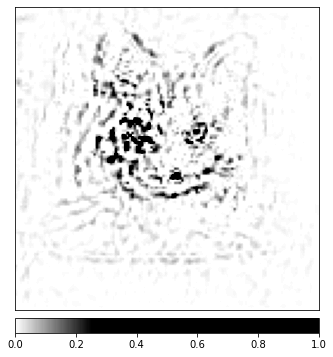

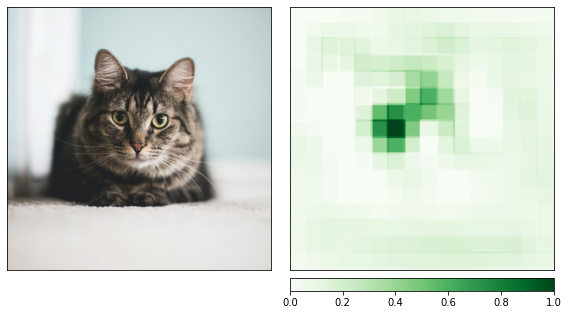

Predicted: Dog ( 0.9999992847442627 )


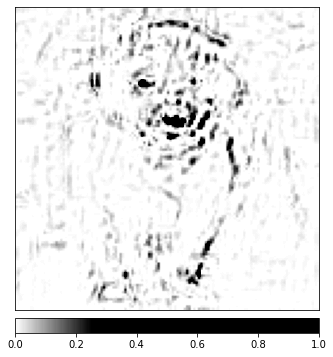

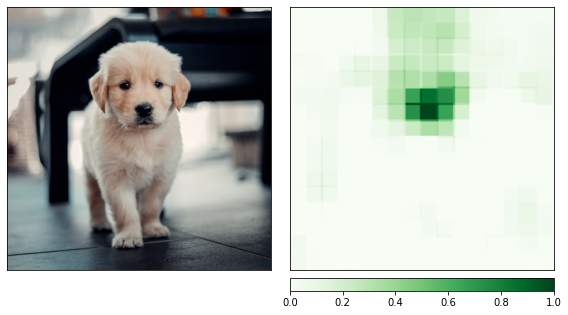

In [73]:
external_test_images = []
external_test_images += [os.path.join('./test_images/CatVsDog/', im) for im in os.listdir('./test_images/CatVsDog/')]
run_test_captum(model_aug, external_test_images, test_cat_vs_dog)

We see that in both cases, the animal's face and ear-region are contributing to the classification. Occlusion-based attribution gives more focus to the face and nose region as well, while the gradient-based methods cover both the face and the ears.